In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from plotting import plot_sample, plot_calibration_curve, plot_fitted_calibrator, plot_calibration_info_for_models
import h2o
from h2o.estimators import H2ODeepLearningEstimator, H2ONaiveBayesEstimator
from model import CalibratableModelFactory

h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 28 mins
H2O_cluster_timezone:,Europe/Belgrade
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.5
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_wojciech_blachowski_h4jbxg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.723 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


# Data

In [2]:
X_full, y_full = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [3]:
positive_idx = y_full.astype(np.int32)%2==0
negative_idx = np.invert(positive_idx)

X_positive, y_positive = X_full[positive_idx], y_full[positive_idx]
X_negative, y_negative = X_full[negative_idx], y_full[negative_idx]

print(f'Number of positive examples: {len(X_positive)}')
print(f'Number of negative examples: {len(X_negative)}')

Number of positive examples: 34418
Number of negative examples: 35582


In [4]:
permutation = np.random.permutation(len(X_negative))[:len(X_positive)]
X_negative, y_negative = X_negative[permutation], y_negative[permutation]

In [5]:
print(f'Number of positive examples: {len(X_positive)}')
print(f'Number of negative examples: {len(X_negative)}')
print(Counter(y_positive).most_common())
print(Counter(y_negative).most_common())

Number of positive examples: 34418
Number of negative examples: 34418
[('2', 6990), ('0', 6903), ('6', 6876), ('8', 6825), ('4', 6824)]
[('1', 7627), ('7', 7015), ('3', 6919), ('9', 6748), ('5', 6109)]


In [6]:
X = np.concatenate((X_positive, X_negative))
y = np.concatenate((np.ones(len(X_positive)), np.zeros(len(X_negative))))
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

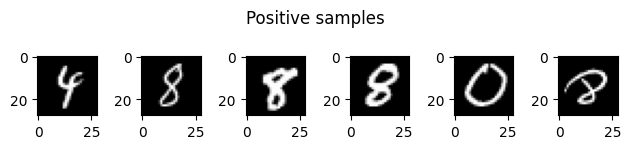

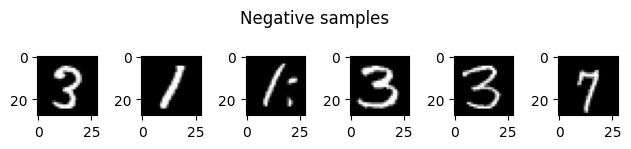

In [7]:
plot_sample(X_positive, "Positive samples")
plot_sample(X_negative, "Negative samples")

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_test, X_calib, y_test, y_calib = train_test_split(X_test, y_test, train_size=0.5)

print(f"Train length: {len(X_train)}")
print(f"Test length: {len(X_test)}")
print(f"Calib length: {len(X_calib)}")

Train length: 55068
Test length: 6884
Calib length: 6884


In [9]:
X_train_unscaled = np.copy(X_train)
X_test_unscaled = np.copy(X_test)
X_calib_unscaled = np.copy(X_calib)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_calib = scaler.transform(X_calib)

# Calibration

C:\Users\wojciech.blachowski\Miniconda3\envs\calibration\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9002033701336433


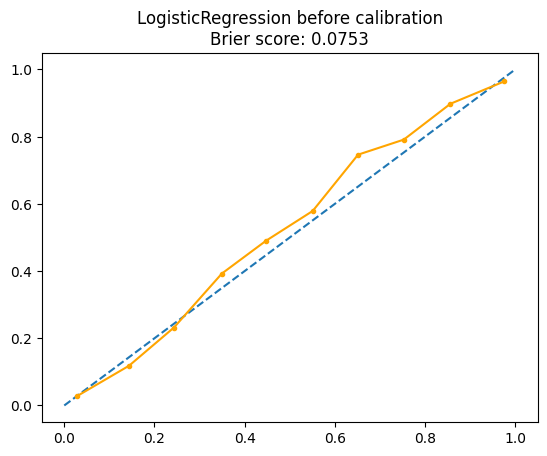

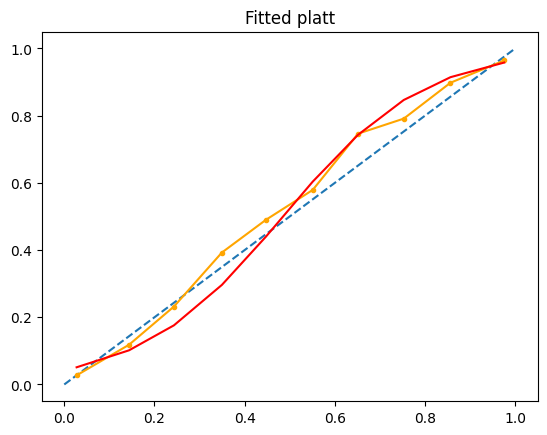

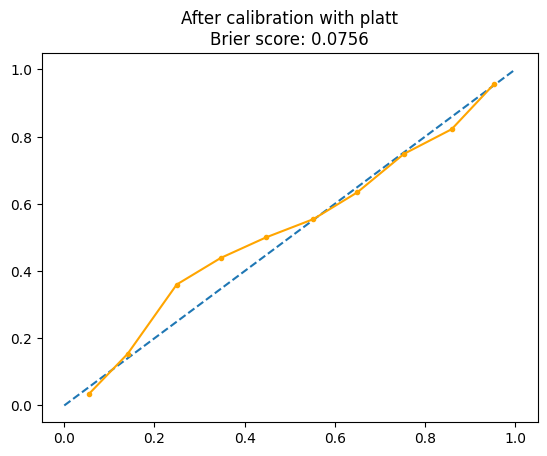

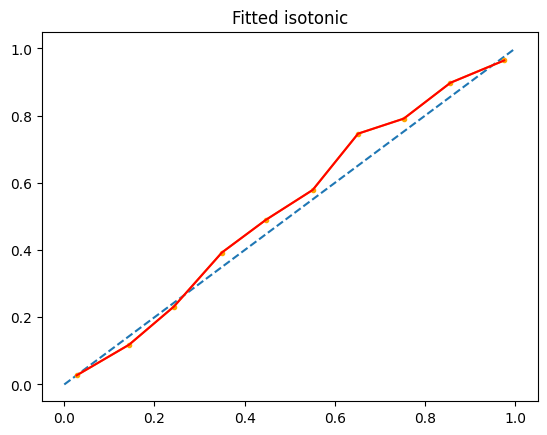

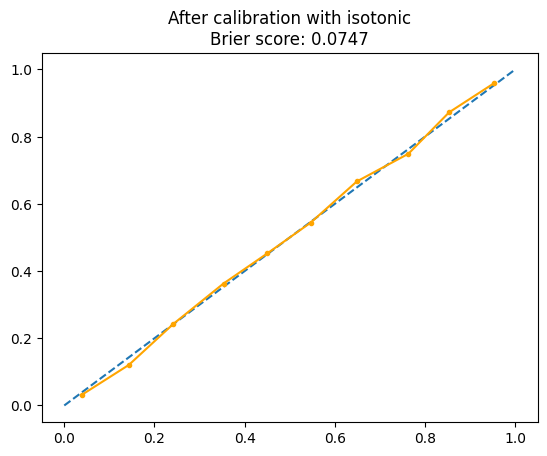

C:\Users\wojciech.blachowski\Miniconda3\envs\calibration\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.8927948866937827


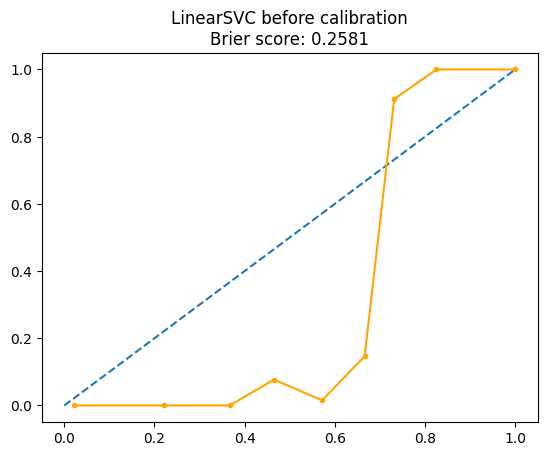

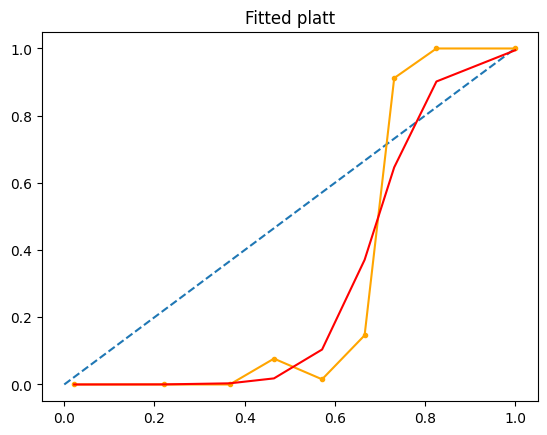

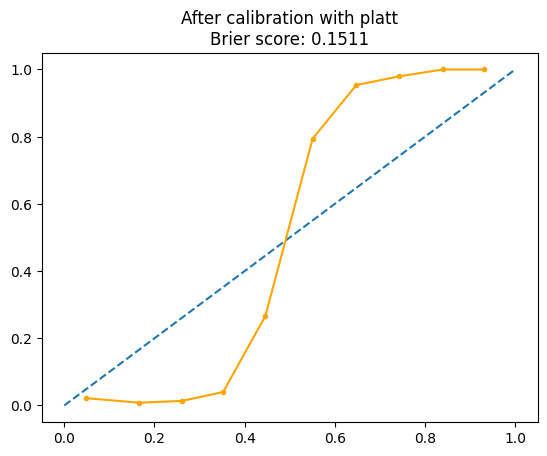

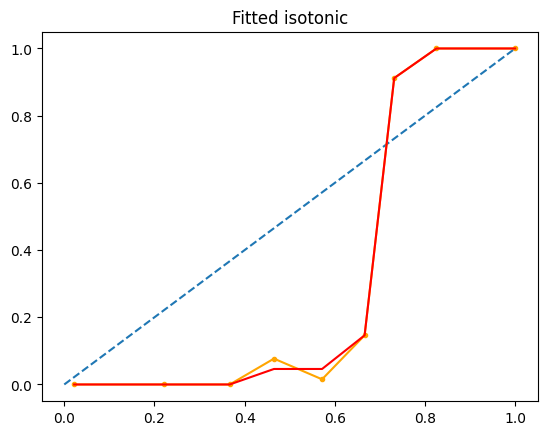

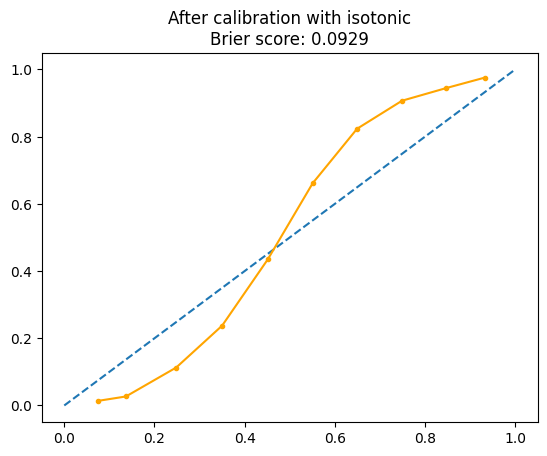

0.9771934921557234


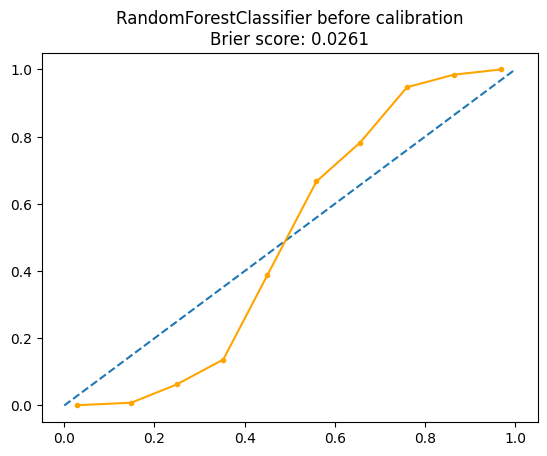

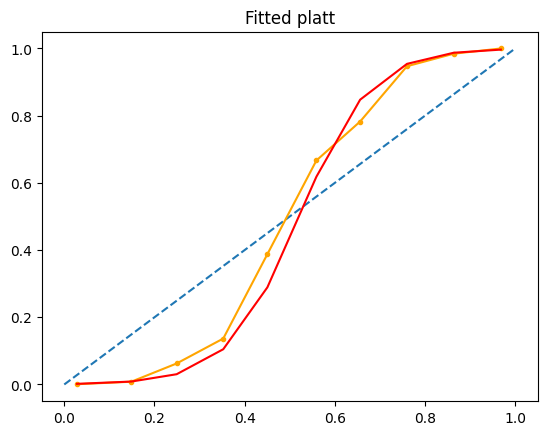

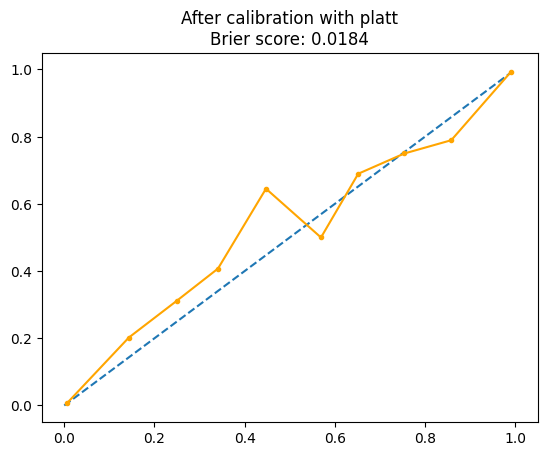

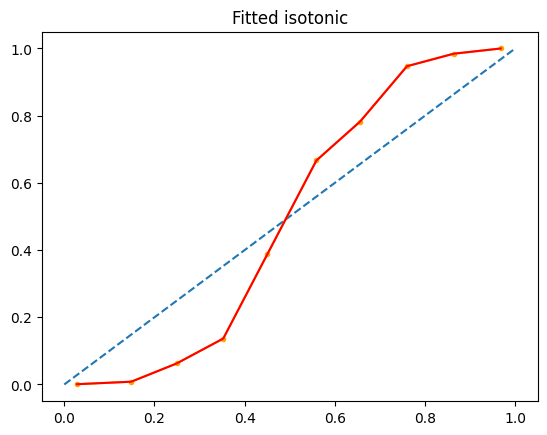

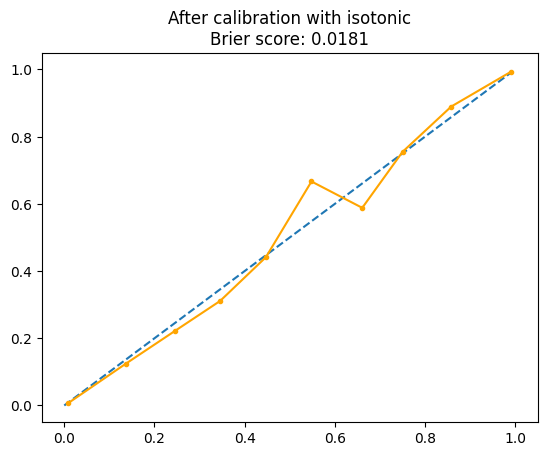

C:\Users\wojciech.blachowski\Miniconda3\envs\calibration\lib\site-packages\h2o\estimators\estimator_base.py:201: RuntimeWarning: Dropping bad and constant columns: [671, 111, 672, 112, 673, 476, 754, 755, 756, 757, 758, 759, 52, 53, 10, 54, 11, 55, 56, 57, 14, 15, 16, 17, 18, 19, 560, 0, 1, 364, 2, 3, 168, 4, 5, 6, 644, 7, 8, 9, 727, 728, 20, 729, 21, 22, 23, 24, 25, 26, 27, 28, 29, 532, 730, 699, 30, 31, 140, 780, 781, 782, 783, 700, 701, 82, 83, 84, 85]
  warnings.warn(mesg["message"], RuntimeWarning)


0.7723707147007554


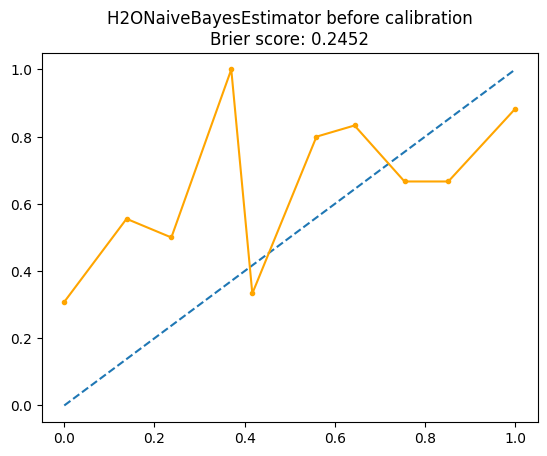

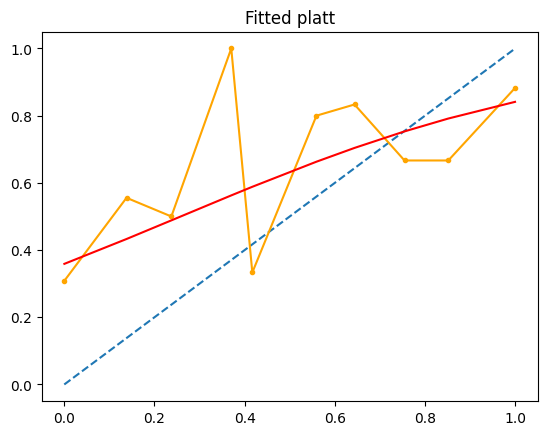

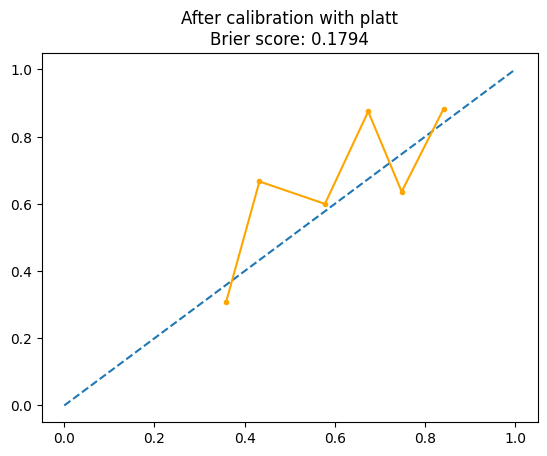

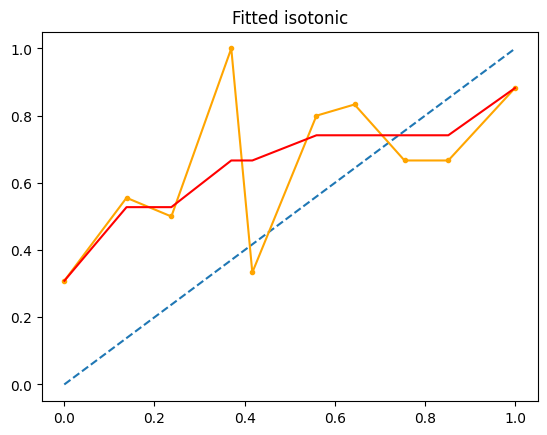

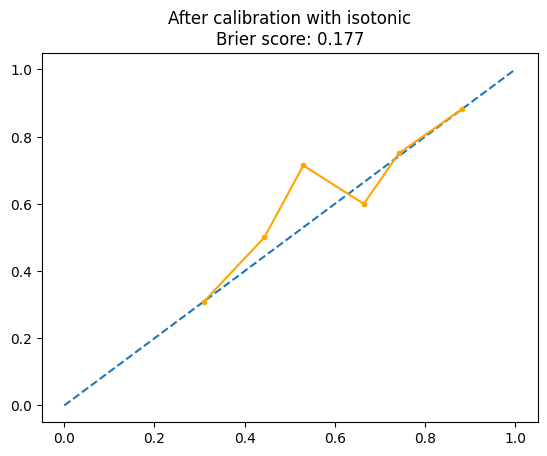

C:\Users\wojciech.blachowski\Miniconda3\envs\calibration\lib\site-packages\h2o\estimators\estimator_base.py:201: RuntimeWarning: Dropping bad and constant columns: [671, 111, 672, 112, 673, 476, 754, 755, 756, 757, 758, 759, 52, 53, 10, 54, 11, 55, 56, 57, 14, 15, 16, 17, 18, 19, 560, 0, 1, 364, 2, 3, 168, 4, 5, 6, 644, 7, 8, 9, 727, 728, 20, 729, 21, 22, 23, 24, 25, 26, 27, 28, 29, 532, 730, 699, 30, 31, 140, 780, 781, 782, 783, 700, 701, 82, 83, 84, 85]
  warnings.warn(mesg["message"], RuntimeWarning)


0.9854735618826264


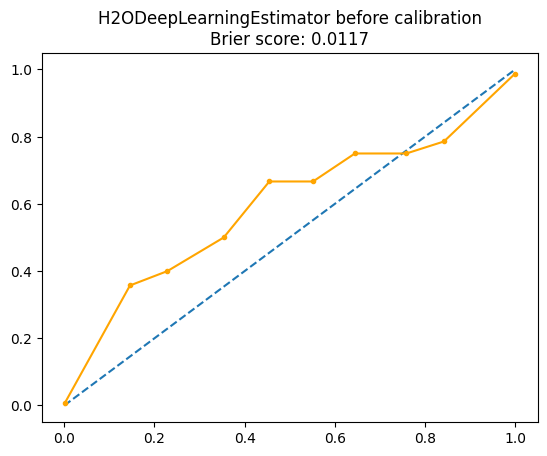

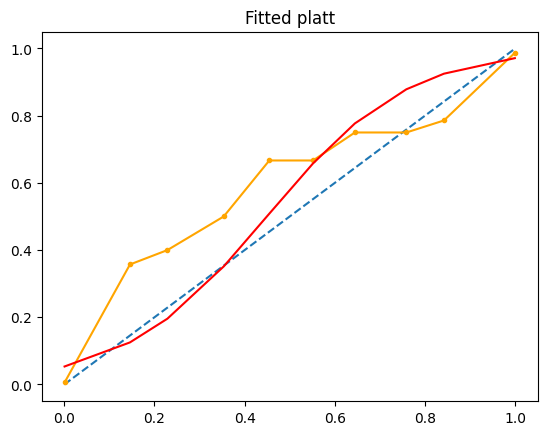

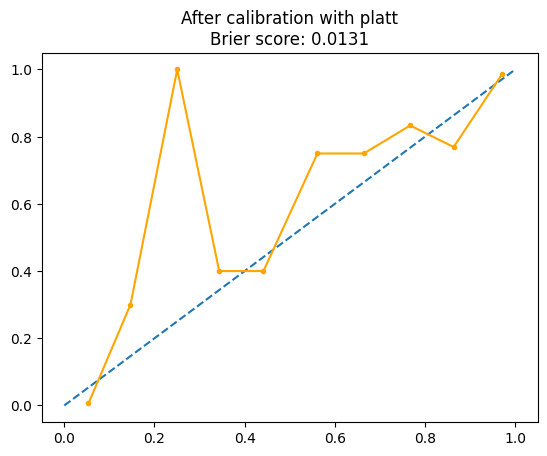

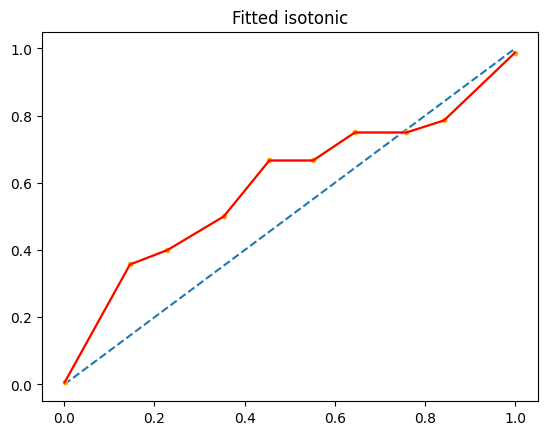

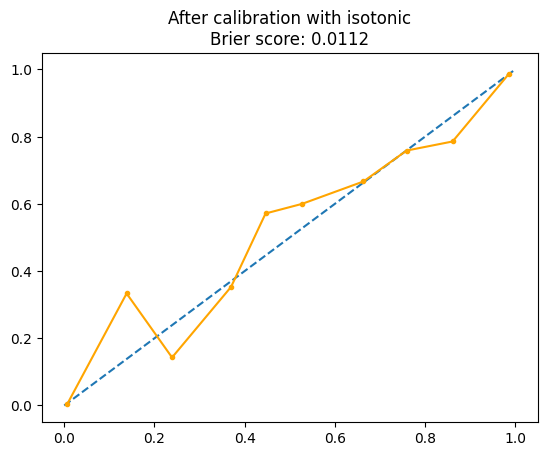

In [11]:
factory = CalibratableModelFactory()
lr = factory.get_model(LogisticRegression())
svc = factory.get_model(LinearSVC())
rfc = factory.get_model(RandomForestClassifier())
nb = factory.get_model(H2ONaiveBayesEstimator())
dl = factory.get_model(H2ODeepLearningEstimator())

models = [lr, svc, rfc, nb, dl]

for model in models:
    model.train(X_train, y_train)
    print(model.score(X_test, y_test))
    model.calibrate(X_calib, y_calib)
    
    prob_true, prob_pred = plot_calibration_curve(y_calib, model.predict(X_calib), f'{model.name} before calibration')
    for method in ['platt', 'isotonic']:
        plot_fitted_calibrator(prob_true, prob_pred, model.calibrate_probabilities(prob_pred, method), f'Fitted {method}')
        plot_calibration_curve(y_calib, model.predict_calibrated(X_calib, method), f'After calibration with {method}')

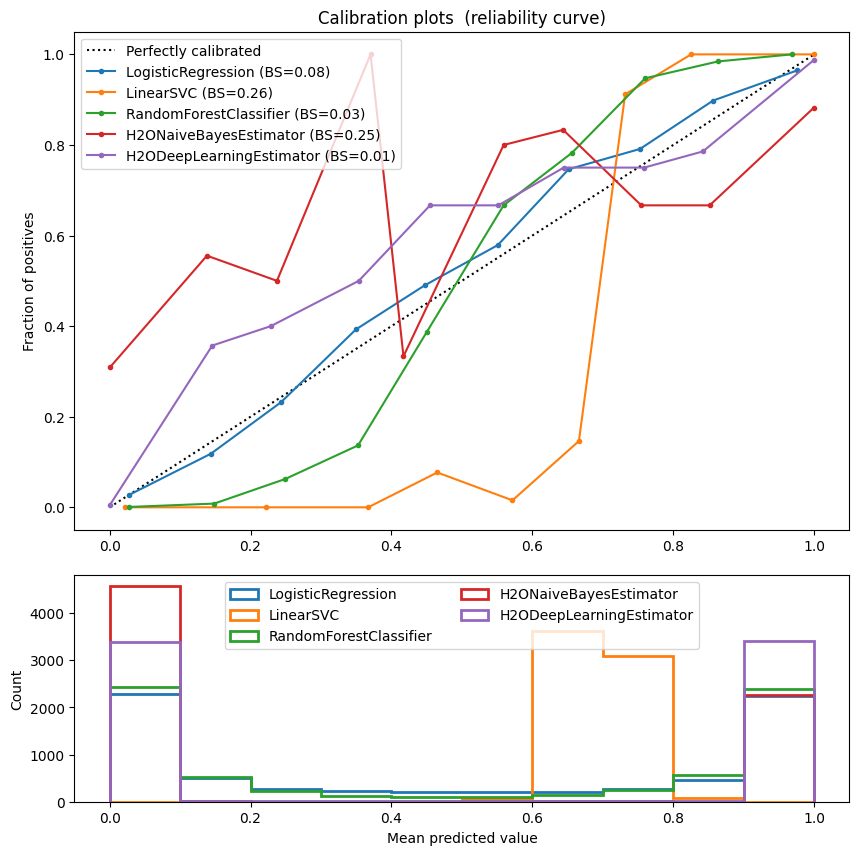

In [12]:
plot_calibration_info_for_models(models, X_calib, y_calib)